In [2]:
# imports
import pandas as pd
import numpy as np
import os
import datetime
import tradingeconomics as te
from datetime import datetime, timedelta
import matplotlib.pyplot as plt

te.login('86A02B2788834D4:AD2DEAA48B0144C')

pd.set_option('display.max_rows', 15)
pd.set_option('display.max_columns', 15)

## 1. Train set preparation

In [2]:
# Retrieve historical data for the first date range

instrument = 'EURUSD:CUR'

start_date = '1970-01-01'

df = te.getHistorical(symbol=instrument, output_type='df', initDate=start_date, endDate='2023-12-31')
df.set_index('Date', inplace=True)
df.index = pd.to_datetime(df.index, format='%d/%m/%Y')
df.drop('Symbol', axis=1, inplace=True)
df.sort_index(ascending=True, inplace=True)

# Retrieve historical data for the second date range
df_2 = te.getHistorical(symbol=instrument, output_type='df', initDate=start_date, endDate='1986-08-04')
df_2.set_index('Date', inplace=True)
df_2.index = pd.to_datetime(df_2.index, format='%d/%m/%Y')
df_2.drop('Symbol', axis=1, inplace=True)
df_2.sort_index(ascending=True, inplace=True)

# Combine both DataFrames
df = pd.concat([df_2, df])

# Sort the combined DataFrame by index
df.sort_index(ascending=True, inplace=True)

df.to_csv('../data/eurusd_daily.csv')

In [ ]:
"""df = pd.read_csv('../data/eurusd_daily.csv', index_col=0)
df.index = pd.to_datetime(df.index)"""

In [4]:
df = df[df.index < '2010-01-01']

In [5]:
df = df[df.apply(lambda row: len(set(row[['Open', 'High', 'Low', 'Close']])) > 1, axis=1)]

<Axes: xlabel='Date'>

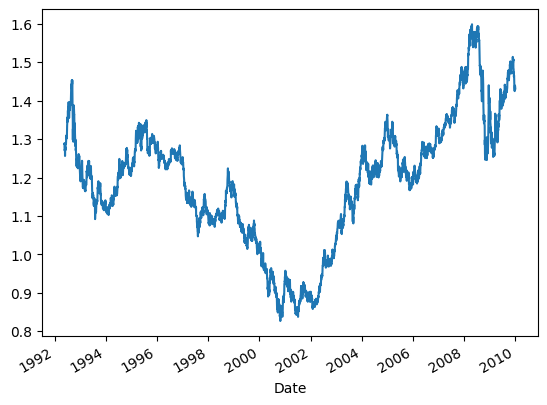

In [6]:
df['Close'].plot()

### Simulating the 15-minute train set

In [8]:
# Function to simulate intra-day prices and create a DataFrame
def simulate_intraday_prices_to_df(date, open_price, high_price, low_price, close_price):
    intervals=96
    
    # Generate timestamps for the 15-minute intervals
    timestamps = pd.date_range(start=date, periods=intervals, freq='15T')
    
    # Array to hold the prices
    prices = np.zeros(intervals)
    prices[0] = open_price
    prices[-1] = close_price
    
    # Define the maximum allowed change per interval to avoid unrealistic jumps
    max_step = (high_price - low_price) / 10  # Example max step size

    # Generate intermediate prices
    for i in range(1, intervals - 1):
        # Random step, adjusted for a gentle slope towards close
        step = (close_price - prices[i - 1]) / (intervals - i) + np.random.uniform(-max_step, max_step)
        
        # Ensure the step does not exceed the day's high or low
        next_price = prices[i - 1] + step
        next_price = max(min(next_price, high_price), low_price)
        
        prices[i] = next_price

    # Create DataFrame with timestamps as the index and prices as the column
    df_intraday = pd.DataFrame({
        'Price': prices
    }, index=timestamps)

    return df_intraday

In [9]:
row = df.iloc[1, :]
df_intraday = simulate_intraday_prices_to_df(row.name, row.Open, row.High, row.Low, row.Close)

In [10]:
for index, row in df.iloc[1:].iterrows():
    df_intraday_current = simulate_intraday_prices_to_df(row.name, row.Open, row.High, row.Low, row.Close)    
    df_intraday = pd.concat([df_intraday, df_intraday_current])

<Axes: >

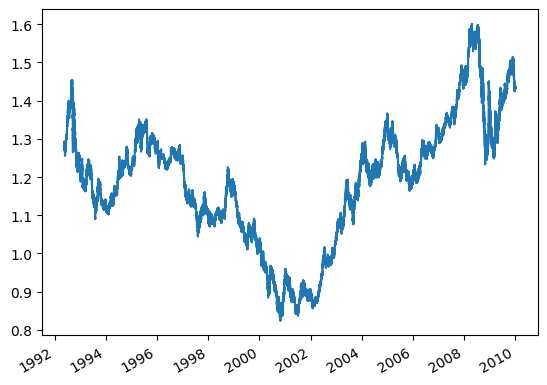

In [11]:
df_intraday['Price'].plot()

In [12]:
df_intraday.shape

(440544, 1)

In [13]:
# df_intraday.to_csv('../data/eurusd_train_set_15_min_simulated.csv')

In [3]:
df_train = pd.read_csv('../data/eurusd_train_set_15_min_simulated.csv', index_col = 0)
df_train.index = pd.to_datetime(df_train.index)

## 2. Test set creation

In [70]:
df_test = pd.read_csv('../data/EURUSD_15m_BID_01.01.2010-31.12.2016.csv')
df_test.rename(columns={'Time': 'Date'}, inplace=True)
df_test.set_index('Date', inplace=True)
df_test.index = pd.to_datetime(df_test.index)
df_test.rename(columns = {'Close': 'Price'}, inplace=True)
df_test = df_test['Price']
df_test = pd.DataFrame(df_test)

In [71]:
df_test

,Price
Date,
2010-01-01 00:00:00,1.43293
2010-01-01 00:15:00,1.43275
2010-01-01 00:30:00,1.43281
2010-01-01 00:45:00,1.43276
2010-01-01 01:00:00,1.43282
...,...
2016-12-31 22:45:00,1.05150
2016-12-31 23:00:00,1.05150
2016-12-31 23:15:00,1.05150


In [64]:
df_train

,Price,bollinger_hband,bollinger_lband,ulcer_index,sma,ema,wma,...,rsi,stochrsi,tsi,kama,roc,ppo,ppo_signal
1992-05-19 17:45:00,1.287140,1.287961,1.285914,0.101646,1.287220,1.287193,1.287258,...,49.979155,0.648599,1.103238,1.287199,0.060005,0.002079,-0.003157
1992-05-19 18:00:00,1.287740,1.288061,1.285899,0.081856,1.287245,1.287292,1.287353,...,54.675684,0.920505,2.395315,1.287204,0.142087,0.005446,-0.001437
1992-05-19 18:15:00,1.287827,1.288148,1.285871,0.070809,1.287265,1.287389,1.287459,...,55.335755,0.958720,3.633472,1.287209,0.100242,0.008565,0.000564
1992-05-19 18:30:00,1.288703,1.288444,1.285730,0.054176,1.287444,1.287628,1.287720,...,61.389903,1.000000,6.653017,1.287334,0.094391,0.016339,0.003719
1992-05-19 18:45:00,1.289586,1.288957,1.285497,0.043251,1.287791,1.287984,1.288109,...,66.339536,1.000000,10.964790,1.287878,0.152675,0.027711,0.008517
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2009-12-31 22:45:00,1.430500,1.432580,1.429919,0.134980,1.431207,1.431080,1.431062,...,43.371850,0.256034,-9.240978,1.432227,0.000000,-0.028350,-0.031341
2009-12-31 23:00:00,1.430500,1.432521,1.429843,0.129981,1.431140,1.430975,1.430934,...,43.371850,0.256034,-9.806613,1.432195,0.000000,-0.029742,-0.031021
2009-12-31 23:15:00,1.431898,1.432343,1.429943,0.117563,1.431105,1.431143,1.431072,...,52.325883,1.000000,-7.558624,1.432192,0.097702,-0.022703,-0.029357
2009-12-31 23:30:00,1.431179,1.432330,1.429938,0.105372,1.431067,1.431149,1.431085,...,48.113240,0.642702,-6.954345,1.432181,0.000969,-0.020936,-0.027673


## 3. Creating the technical indicators derived from the price

In [41]:
import ta

In [51]:
# Volatility Indicators
# Bollinger Bands (BB)
bollinger = ta.volatility.BollingerBands(df_train['Price'])
df_train.loc[:, 'bollinger_hband'] = bollinger.bollinger_hband()
df_train.loc[:, 'bollinger_lband'] = bollinger.bollinger_lband()

# Ulcer Index (UI)
df_train.loc[:, 'ulcer_index'] = ta.volatility.UlcerIndex(df_train['Price']).ulcer_index()

# Trend Indicators
# Simple Moving Average (SMA)
df_train.loc[:, 'sma'] = ta.trend.SMAIndicator(df_train['Price'], window=10).sma_indicator()

# Exponential Moving Average (EMA)
df_train.loc[:, 'ema'] = ta.trend.EMAIndicator(df_train['Price'], window=10).ema_indicator()

# Weighted Moving Average (WMA)
df_train.loc[:, 'wma'] = ta.trend.WMAIndicator(df_train['Price'], window=10).wma()

# Moving Average Convergence Divergence (MACD)
macd = ta.trend.MACD(df_train['Price'])
df_train.loc[:, 'macd'] = macd.macd()

# Trix (TRIX)
df_train.loc[:, 'trix'] = ta.trend.TRIXIndicator(df_train['Price']).trix()

# Detrended Price Oscillator (DPO)
df_train.loc[:, 'dpo'] = ta.trend.DPOIndicator(df_train['Price']).dpo()

# KST Oscillator (KST)
kst = ta.trend.KSTIndicator(df_train['Price'])
df_train.loc[:, 'kst'] = kst.kst()

# Schaff Trend Cycle (STC)
df_train.loc[:, 'stc'] = ta.trend.STCIndicator(df_train['Price']).stc()

# Aroon Indicator
aroon = ta.trend.AroonIndicator(df_train['Price'])
df_train.loc[:, 'aroon_down'] = aroon.aroon_down()
df_train.loc[:, 'aroon_up'] = aroon.aroon_up()

# Momentum Indicators
# Relative Strength Index (RSI)
df_train.loc[:, 'rsi'] = ta.momentum.RSIIndicator(df_train['Price']).rsi()

# Stochastic RSI (SRSI)
srsi = ta.momentum.StochRSIIndicator(df_train['Price'])
df_train.loc[:, 'stochrsi'] = srsi.stochrsi()

# True Strength Index (TSI)
df_train.loc[:, 'tsi'] = ta.momentum.TSIIndicator(df_train['Price']).tsi()

# Kaufman's Adaptive Moving Average (KAMA)
df_train.loc[:, 'kama'] = ta.momentum.KAMAIndicator(df_train['Price']).kama()

# Rate of Change (ROC)
df_train.loc[:, 'roc'] = ta.momentum.ROCIndicator(df_train['Price']).roc()

# Percentage Price Oscillator (PPO)
ppo = ta.momentum.PercentagePriceOscillator(df_train['Price'])
df_train.loc[:, 'ppo'] = ppo.ppo()
df_train.loc[:, 'ppo_signal'] = ppo.ppo_signal()

In [56]:
df_train.shape

(440544, 21)

In [57]:
df_train.dropna(inplace=True)

In [58]:
df_train.shape

(440473, 21)

In [72]:
# Volatility Indicators
# Bollinger Bands (BB)
bollinger = ta.volatility.BollingerBands(df_test['Price'])
df_test.loc[:, 'bollinger_hband'] = bollinger.bollinger_hband()
df_test.loc[:, 'bollinger_lband'] = bollinger.bollinger_lband()

# Ulcer Index (UI)
df_test.loc[:, 'ulcer_index'] = ta.volatility.UlcerIndex(df_test['Price']).ulcer_index()

# Trend Indicators
# Simple Moving Average (SMA)
df_test.loc[:, 'sma'] = ta.trend.SMAIndicator(df_test['Price'], window=10).sma_indicator()

# Exponential Moving Average (EMA)
df_test.loc[:, 'ema'] = ta.trend.EMAIndicator(df_test['Price'], window=10).ema_indicator()

# Weighted Moving Average (WMA)
df_test.loc[:, 'wma'] = ta.trend.WMAIndicator(df_test['Price'], window=10).wma()

# Moving Average Convergence Divergence (MACD)
macd = ta.trend.MACD(df_test['Price'])
df_test.loc[:, 'macd'] = macd.macd()

# Trix (TRIX)
df_test.loc[:, 'trix'] = ta.trend.TRIXIndicator(df_test['Price']).trix()

# Detrended Price Oscillator (DPO)
df_test.loc[:, 'dpo'] = ta.trend.DPOIndicator(df_test['Price']).dpo()

# KST Oscillator (KST)
kst = ta.trend.KSTIndicator(df_test['Price'])
df_test.loc[:, 'kst'] = kst.kst()

# Schaff Trend Cycle (STC)
df_test.loc[:, 'stc'] = ta.trend.STCIndicator(df_test['Price']).stc()

# Aroon Indicator
aroon = ta.trend.AroonIndicator(df_test['Price'])
df_test.loc[:, 'aroon_down'] = aroon.aroon_down()
df_test.loc[:, 'aroon_up'] = aroon.aroon_up()

# Momentum Indicators
# Relative Strength Index (RSI)
df_test.loc[:, 'rsi'] = ta.momentum.RSIIndicator(df_test['Price']).rsi()

# Stochastic RSI (SRSI)
srsi = ta.momentum.StochRSIIndicator(df_test['Price'])
df_test.loc[:, 'stochrsi'] = srsi.stochrsi()

# True Strength Index (TSI)
df_test.loc[:, 'tsi'] = ta.momentum.TSIIndicator(df_test['Price']).tsi()

# Kaufman's Adaptive Moving Average (KAMA)
df_test.loc[:, 'kama'] = ta.momentum.KAMAIndicator(df_test['Price']).kama()

# Rate of Change (ROC)
df_test.loc[:, 'roc'] = ta.momentum.ROCIndicator(df_test['Price']).roc()

# Percentage Price Oscillator (PPO)
ppo = ta.momentum.PercentagePriceOscillator(df_test['Price'])
df_test.loc[:, 'ppo'] = ppo.ppo()
df_test.loc[:, 'ppo_signal'] = ppo.ppo_signal()

In [74]:
df_test.shape

(245444, 21)

In [75]:
df_test.dropna(inplace=True)

In [76]:
df_test.shape

(224933, 21)

In [80]:
df_train.to_csv('../data/df_train.csv')

In [81]:
df_test.to_csv('../data/df_test.csv')